#### CSCI-UA.0473-​001 Introduction to Machine Learning

# Homework 2


### Name: Michael Perillo


### Due: Oct. 14, 2020


## Goal:  The goal of this homework is to practice implementing a dual form of a linear support vector machine without the optimizing algorithm.

Please DO NOT change the position of any cell in this assignment. Read every line till the end, and try your best implement everything.  

You will need the following packages below to do the homework.  Please DO NOT import any other packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## 1. Implementing Linear SVM (55 pts total)

In this problem you will implement linear SVM by solving the dual problem and apply it to the Iris dataset.  The original dataset has 4 features with 3 classes, but in this homework we'll only use the first two features and ignore the first class (to make this a binary classification problem).

### Loading and spliting the data (nothing to do)

The following cell loads the data and pre-processes it to be used for training later.  **Do not modify anything in this cell**.

In [2]:
# Load in the data.
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Ignore the first class and use only the first 2 features.
X = X[y != 0, :2]
y = y[y != 0]

# Make sure that the class labels are either +1 or -1.
y[y==2] = -1

n_sample = len(X)

# Randomly order the data.
np.random.seed(0)
order = np.random.permutation(n_sample)
X = X[order]
y = y[order].astype(np.float)

# Split the data into 10% testing and 90% training.
X_train = X[:int(.9 * n_sample)]
y_train = y[:int(.9 * n_sample)]
X_test = X[int(.9 * n_sample):]
y_test = y[int(.9 * n_sample):]

### Part (a) (5 pts) Computing the matrix of inner products.

For training data $X\in\mathbb{R}^{n\times p}, x_i\in\mathbb{R}^{p}$, the inner product matrix is
$
\mathbf{M}=(m_{ij})\in\mathbb{R}^{n\times n},\quad m_{ij}=\langle x_i, x_j\rangle\in\mathbb{R}.
$
Implement the following function below that takes in the matrix $X$ of training data and returns the corresponding inner product matrix $\mathbf{M}$.  For this you may use the numpy function `np.dot()`.  Also answer the following two questions below.

1. What is the fewest number of inner products do you need to compute?  Explain why.

Since dot products are commutative, we have $m_{ij}=m_{ji}$. If $i=j$, we only need to
square the vector's entries and compute the sum of those terms. Realistically, we should only
need to compute dot products for the lower triangle and the diagonal of the matrix, as
the matrix should be symmetrical.

2. What are the diagonal entries of the matrix $\mathbf{M}$?

Since entries in the matrix $\mathbf{M}$ are defined as $m_{ij}=\langle x_i, x_j\rangle$,
and a diagonal entry has $i=j$, we have for all diagonal entries $m_{i=j}=\langle x_i, x_i\rangle$.
From the definition of the dot product, we know that for some vector $u$, $u \cdot u=\lvert u \rvert ^2$.
Therefore, the diagonal entries of the inner product matrix will be the square
of the $i$th vector's magnitude.

**Answer goes here**


In [3]:
def inner_product_matrix(X):
    """
    Compute the inner product matrix of the training data X where each row is a different data point x_i.
    
    Input:
        X: np.ndarray(n, p), n data points in dimension of p
    
    Return:
        M: np.ndarray(n, n), each entry is the inner product of the corresponding pair of vectors m_{ij}
    """
    n = X.shape[0]
    M = np.ndarray((n, n))
    for i in range(n):
        for j in range(n - i):
            # j's range ensures we only calculate dot products for half
            # of the values in M.
            insert = np.dot(X[i], X[j])
            M[i][j] = M[j][i] = insert
    return M

### Part (b) (10 pts) The dual problem for linear SVM

Recall that for linear SVM the dual problem is
\begin{align*}
\max_{\alpha} W(\alpha) &= \sum_{i=1}^n \alpha_i - \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n} y_i y_j \alpha_i \alpha_j \langle x_i, x_j\rangle \\
\text{s.t.} & \quad 0 \le \alpha_i \le C, \quad i = 1,\ldots,n \\
& \sum_{i=1}^n \alpha_i y_i = 0
\end{align*}
where $\alpha \in \mathbb{R}^n$ is a vector.  


Implement the objective function $W(\alpha)$ which also takes the training data features and labels as parameters.  Do not worry about the constraints for the moment since you will deal with these next.

* You may also find the function `np.diag()` useful to help vectorize your code and make it run faster.

In [4]:
def objective_function(a, X, y):
    """
    The objective function of the dual problem W.
    
    Input:
        a: np.ndarray(n,), the parameter alpha we want to optimize
        X: np.ndarray(n, p), the matrix of training data features
        y: np.ndarray (n,), the vector of training data labels, must be either +1 or -1.
    
    Return:
        W: float, value of the objective function. 
    """
    
    ##TODO-start##
    X_inner = inner_product_matrix(X)
    alpha_sum = np.sum(a)
    double_sum = 0
    for i in range(X_inner.shape[0]):
        for j in range(X_inner.shape[1]):
            double_sum += ((y[i] * y[j]) * (a[i] * a[j]) * X_inner[i][j])
    W = float(alpha_sum) - (0.5 * float(double_sum))
    ##TODO-end##
    return W

### Part (c) (35 pts) Implementing the `fit()` function. 

Instead of writing your own optimization algorithm, use the scipy function `scipy.optimize.minimize()` to automatically optimize $\alpha$. (Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) 
* Note that the `minimize()` function minimizes the objective function, so you'll need to reformulate the dual problem as a minimization problem with the following trick:
* $\alpha^* = \text{argmax}_{\alpha}[W(\alpha)]=\text{argmin}_{\alpha}[-W(\alpha)]$


There are several pieces you will need to implement.  Read the documentation carefully to set everythign up correctly.

1. Get the box constraints $0 \le \alpha_i \le C$ for $i=1,\ldots,n$.  You will pass this into `minimize()` as the `bounds` argument.

2. Get the linear constraint $\sum_{i=1}^n \alpha_i y_i = 0$.  You will pass this into `minimize()` as the `constraints` argument.

3. Call `minimize()` using the correct objective function $-W(\alpha)$ as well as the constraints and bounds from the previous 2 parts.  Use $\alpha_0 = 0 \in \mathbb{R}^n$ as the initial point and use the SLSQP method.

4. Compute the primal variable $w \in \mathbb{R}^p$ using the formula
$
    w = \sum_{i=1}^n \alpha_i y_i x_i
$

4. Compute the bias term using the formula
$
     b = \frac{1}{n} \sum_{i=1}^{n}\left(y_i - \sum_{j=1}^n \alpha_j y_j \langle x_j, x_i \rangle \right) = \frac{1}{n} \sum_{i=1}^n \left(y_i - w^T x_i \right)
$
once you have computed the minimizer $\alpha$.


Hints:
* Read the explanations of `fun`, `x0`, `bounds`, `constraints`, corresponding to objective function, initialization, bounds, and constraints.
* Equality constraints mean that the constraint function result is zero.
* If `res = minimize(...)`, then `res.x` is the minimizer.

In [5]:
def fit(X, y, C):
    """
    Computes the parameters alpha and bias that determine the maximum-margin decision boundary for SVM.
    
    Input:
        X: np.ndarray(n,p), matrix of training data features
        y: np.ndarray(n, ), vector of training data labels
        C: float, slack parameter that is non-negative
        
    Return:
        w: np.ndarray(p,), vector of primal variable values (vector orthogonal to decision boundary)
        bias: float, the bias term in SVM
        alpha: np.ndarray(n, ), vector of dual variable values
    """
    ## TO-DO STARTS HERE##
    # I know we arent supposed to redifine functions, but I had no idea how to get the
    # callable to be negative since it always returns a positive number. Hopefully this is okay!
    def neg_objective_function(a, X, y):
        """
        The objective function of the dual problem W.

        Input:
            a: np.ndarray(n,), the parameter alpha we want to optimize
            X: np.ndarray(n, p), the matrix of training data features
            y: np.ndarray (n,), the vector of training data labels, must be either +1 or -1.

        Return:
            W: float, value of the objective function, times negative one.
        """

        ##TODO-start##
        X_inner = inner_product_matrix(X)
        alpha_sum = np.sum(a)
        double_sum = 0
        for i in range(X_inner.shape[0]):
            for j in range(X_inner.shape[1]):
                double_sum += ((y[i] * y[j]) * (a[i] * a[j]) * X_inner[i][j])
        W = float(alpha_sum) - (0.5 * float(double_sum))
        ##TODO-end##
        return W * -1

    box_constraints = np.asarray([(0, C) for i in range(y.shape[0])])
    initial = np.zeros(y.shape[0])
    initial[0] = 0
    alpha = minimize(neg_objective_function, initial, args=(X, y),
                     method='SLSQP',
                     bounds=box_constraints,
                     constraints={'type': 'eq',
                                  'fun': (lambda x: np.sum([(x[i] * y[i]) for i in range(y.shape[0])]))}).x
    # Compute the primal variables w.
    w = np.zeros(X.shape[1])
    for i in range(y.shape[0]):
        _ = alpha[i] * y[i]
        w += (_ * X[i])
    
    # Compute the bias.
    bias = np.sum([(y[i] - np.inner(w, X[i])) for i in range(y.shape[0])])/y.shape[0]

    ## TO-DO ENDS HERE ##
    return (w, alpha, bias)

### Plotting the results (nothing to do here)
Please DO NOT change anything here. This may take a few minutes to finish the optimization.

* If your implementation is perfect there won't be any errors thrown and it will show a figure similar to the first one in https://scikit-learn.org/stable/auto_examples/exercises/plot_iris_exercise.html#sphx-glr-auto-examples-exercises-plot-iris-exercise-py (ignore if the colors are swapped).

In [6]:
w, alpha, bias = fit(X_train, y_train, C = 10)

c:\users\michael perillo\pycharmprojects\mlnotebooks\venv\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


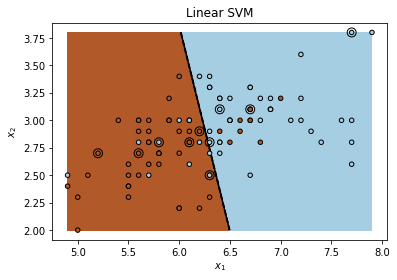

In [7]:
plt.figure(1)
plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired,
            edgecolor='k', s=20)

# Circle out the test data
plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none',
            zorder=10, edgecolor='k')

plt.axis('tight')
x_min = X[:, 0].min()
x_max = X[:, 0].max()
y_min = X[:, 1].min()
y_max = X[:, 1].max()

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
XXYY = np.c_[XX.ravel(), YY.ravel()]
ZZ = []
for i in range(XXYY.shape[0]):
    ZZ.append(XXYY[i]@w + bias)
    
Z = np.array(ZZ)

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
            linestyles=['--', '-', '--'], levels=[-.5, 0, .5])
plt.title('Linear SVM')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()


### Part (d) (5 pts) Implementing the `predict()` function

Implement the `predict()` function below which computes the discriminant function on the test data and returns a vector whose entries are either $+1$ or $-1$.  For this use the primal variable $w$ along with the bias $b$.  You **do not** need to modify the `accuracy()` function or other code in this cell.  If your method is correct you should achieve around 70% accuracy on both training and testing sets.

In [8]:
def predict(x_test, w, bias):
    """
    Compute the predictions y_pred on the test set using only the support vectors.
    
    Input:
        x_test: np.ndarray(n,p), matrix of the test data
        alpha: np.ndarray(n,), vector of the dual variables
        bias: float, the bias term
    
    Output:
        y_pred: np.ndarray(n,), vector of the predicted labels, either +1 or -1
    """
    ##TODO-start##
    print(w)
    y_pred = np.asarray([1 if ((np.dot(w, x_test[k]) + bias) > alpha[k]) else -1 for k in range(x_test.shape[0])])
    return y_pred
    ##TODO-end##


    
def accuracy(y_pred, y_true):
    """
    Computes the accuracy on the test set given the class predictions.
    
    Input:
        y_pred: np.ndarray(n,), vector of predicted class labels
        y_true: np.ndarray(n,), vector of true class labels
    
    Output:
        float, accuracy of predictions
    """
    return np.mean(y_pred*y_true > 0)

y_pred = predict(X_test, w, bias)
y_pred_train = predict(X_train, w, bias)
print("Training accuracy = {:0.2f}%".format(100*accuracy(y_pred_train, y_train)))
print("Testing accuracy = {:0.2f}%".format(100*accuracy(y_pred, y_test)))

[-264.48577448  -70.6246236 ]
[-264.48577448  -70.6246236 ]
Training accuracy = 75.56%
Testing accuracy = 70.00%


## 2. Solving the primal SVM problem with SGD (30 pts total)

In the previous problem we looked at solving the dual problem for a linear SVM.  However, we could have instead solved the primal problem directly

$
\min_{w \in \mathbb{R}^p}\ L(w) = \frac{1}{2} \|w\|^2 + C \sum_{i=1}^n \max\{0,\ 1 - y_i w^T x_i \}
$

This is an unconstrained problem and the loss $\max\{0,\ 1 - y_i w^T x_i \}$ is called the hinge loss.  Note that even though this function is not differentiable when $1-y_i w^T x_i = 0$ we will use stochastic gradient descent anyways.  Technically we will be using the "sub-gradient" but this is not something you need to worry about.  Below is the pseudo-code to train SVM with SGD.

1. Initialize $w_0 \in \mathbb{R}^p$.  A suggested choice is $w_0 = 0$.

2. For iterations $t = 1,\ldots,T$ do
    * Select a training example $(x_i,y_i)$ at random from the dataset.
    * Compute the gradient $\nabla L_{i}(w_{t-1})$ where
    
    $
        L_{i}(w) = \frac{1}{2}\|w\|^2 + C \max\{0, 1- y_i w^T x_i \}
    $
    
    * Update the parameters:
    
    $
        w_t \leftarrow w_{t-1} - \gamma_t \nabla L_i(w_{t-1})
    $
    
    where $\gamma_t > 0$ is the learning rate.

3. Return the final parameters $w_T$.

4. Compute the bias $b$ using the formula
$
    b = \frac{1}{n} \sum_{i=1}^n (y_i - w_T^T x_i)
$

### Part (a) (10 pts) Implementing the loss function.

Implement the loss function for the primal problem

$
L(w) = \frac{1}{2} \|w\|^2 + C \sum_{i=1}^n \max\{0,\ 1 - y_i w^T x_i \}
$

which takes in the training data matrix $X$ and labels $y$ as well as the parameter $C$ as additional arguments.  Use the functions `np.dot()`, `np.max()`, and `np.sum()` to vectorize your code i.e. **do not** use loops.

In [9]:
def loss(w, X, y, C):
    """
    Compute the loss function on all training examples L(w).
    
    Input:
        w: np.ndarray(p,), the vector of parameters for the SVM
        X: np.ndarray(n,p), the training data matrix of features
        y: np.ndarray(n,), the training data vector of labels
        C: float, the penalty parameter in SVM
        
    Return:
        L: float, the loss on the training set.
    """
    L = ((0.5*np.dot(w, w)) + (C * np.sum([np.max(0, 1 - y[k]*np.dot(w, X[k])) for k in range(y.shape[0])])))
    return L

### Part (b) (10 pts) Implementing the gradient of the loss function.

Derive and implement the gradient of the loss function $L_i(w)$, which only considers one training example $(x_i,y_i)$ and is different from the loss function $L(w)$ that you implemented above.  As a reminder

$
    L_i(w) = \frac{1}{2}\|w\|^2 + C \max\{0,\ 1-y_i w^T x_i\}
$

To derive the gradient separate it into two cases: 1. when $y_i w^T x_i > 1$ and 2. when $y_i w^T x_i < 1$.  Don't worry about deriving the gradient when $y_i w^T x_i = 1$ since the function is not differentiable here.  Instead just treat the gradient as the same as when $y_i w^T x_i > 1$.

**Answer goes here**:

The gradient in the first case is just 

$
    \nabla L_i(w) = w
$

since $\max\{0,\ 1-y_i w^T x_i\} = 0$.  In the second case we have $\max\{0,\ 1-y_i w^T x_i\} = 1 - y_i w^T x_i$ so the gradient is

$
    \nabla L_i(w) = w - C y_i x_i
$

In [10]:
def grad_loss(w, x_i, y_i, C):
    """
    Compute the gradient of the loss function L_i(w) at training example (x_i, y_i).
    
    Input:
        w: np.ndarray(p,), vector of SVM parameters
        x_i: np.ndarray(p,), vector of features for one training example
        y_i: float, the label of training example i, must be either +1 or -1
        C: float, the penalty parameter
    
    Return:
        g: np.ndarray(p,), the gradient at w of L_i
    """
    check = np.dot(w, y_i)[0]
    if check >= 1:
        return w
    else:
        return w - (C * (y_i * x_i))

### Part (c) (10 pts) Implementing `fit_sgd()`

Fill in the skeleton code below which behaves similar to `fit()` from the previous problem but instead optimizes the primal objective function using stochastic gradient descent.  You need to do 3 things:

1. Get the random index for the training example.  You will find the function `np.random.randint()` useful for this purpose.

2. Implement the SGD update using your training example with a variable learning rate which is
$\gamma_t = \frac{\text{lr}_0}{t+1}$
where $\text{lr}_0 > 0$ is the initial learning rate.

3. Compute the bias term using your solution $w$.

In [11]:
def fit_sgd(X, y, C, w0, lr0, T):
    """
    Fit the SVM parameters using SGD.
    
    Input:
        X: np.ndarray(n,p), the training data matrix of features
        y: np.ndarray(n,), the training data vector of labels
        C: float, the penalty parameter
        w0: np.ndarray(p,), the initial parameters for the optimization
        lr0: float, the initial learning rate
        T: int, the number of iterations to perfrom
        
    Return:
        w: np.ndarray(p,), the SVM parameters after T iterations of SGD
        b: float, the SVM bias term
    """
    
    n = X.shape[0]  # Number of training samples.
    w = np.copy(w0) # Initial point for optimization.
    
    # Do T iterations.
    for t in range(T):
        
        # Get the random index for the training example.
        ##TODO-start##
        i = np.random.randint(0, n)
        ##TODO-end##
        x_i = X[i]
        y_i = y[i]
        
        
        # Implement the SGD update using your grad_loss function.
        ## TODO-start##
        w -= ((lr0/T) * grad_loss(w, x_i, y_i, C))
        ## TODO-end##
    
    # Compute the bias.  Hint: You have already done this.
    ##TODO-start##
    b = np.sum([(y[k] - np.inner(w, X[k])) for k in range(n)])/n
    ##TODO-end##
    
    return (w, b)

### Comparing to the dual solution (nothing to do here)

Run the following 3 code cells to test your implemenation against the solution to the previous problem.  You should obtain similar accuracies on both the training and testing sets.  To see that the classifiers do the same thing you should also obtain a similar plot to the one from earlier.  Note that the cell below may take a minute to run because it is 1 million iterations of SGD.

In [12]:
w_sgd, b_sgd = fit_sgd(X_train, y_train, 10, np.zeros(X.shape[1]), 1e-3, 1000000)

In [13]:
y_pred_sgd = predict(X_test, w_sgd, b_sgd)
y_pred_train_sgd = predict(X_train, w_sgd, b_sgd)

print("Training accuracy = {:0.2f}%".format(100*accuracy(y_pred_train_sgd, y_train)))
print("Testing accuracy = {:0.2f}%".format(100*accuracy(y_pred_sgd, y_test)))

[-0.00336693 -0.00106367]
[-0.00336693 -0.00106367]
Training accuracy = 51.11%
Testing accuracy = 50.00%


c:\users\michael perillo\pycharmprojects\mlnotebooks\venv\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


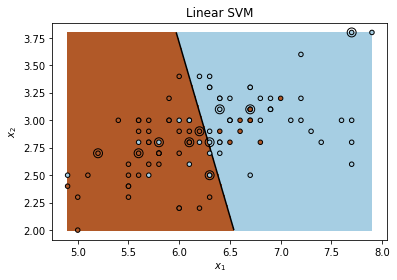

In [14]:
plt.figure(2)
plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired,
            edgecolor='k', s=20)

# Circle out the test data
plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none',
            zorder=10, edgecolor='k')

plt.axis('tight')
x_min = X[:, 0].min()
x_max = X[:, 0].max()
y_min = X[:, 1].min()
y_max = X[:, 1].max()

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
XXYY = np.c_[XX.ravel(), YY.ravel()]
ZZ = []
for i in range(XXYY.shape[0]):
    ZZ.append(XXYY[i]@w_sgd+b_sgd)
    
Z = np.array(ZZ)

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
            linestyles=['--', '-', '--'], levels=[-.5, 0, .5])
plt.title('Linear SVM')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

## 3.  Constrained Optimization (15 pts total)

In this problem you will practice writing down the Lagrangians of different constrained optimization problems.

### Part (a) (5 pts)

Consider the constrained optimization problem

$
\min_{x}\ x^TAx, \quad \text{ such that }\quad \|x\|^2 = 1
$

where $A$ is a real, symmetric, and positive definite matrix.  Write down the Lagrangian and the system of equations that the stationary points must satisfy.

**Answer goes here:**

Lagrangian:

$L(x, \lambda) = x^TAx - \lambda(\|x\|^2 - 1)$

System:

$\nabla_{x}L(x,y,\lambda) = 2Ax - 2\lambda \frac{d(x(t))}{dx}$

$\nabla_{\lambda}L(x,y,\lambda) = \|x\|^2 - 1$


### Part (b) (5 pts)

What are the stationary points of the Lagrangian in terms of the matrix $A$?  In particular, what is the minimizer $x$ and minimal value?  

**Answer goes here:**



### Part (c) (5 pts)

Write down the Lagrangian and system of equations for the stationary points for the following constrained minimization problem.

$
\min_{x,y} 10x^2 + 5y(y - 1), \quad \text{ such that }\quad x + y = 4
$

What is the minimizer $(x,y)$?

**Answer goes here:**

Lagrangian:

$
L(x, y, \lambda)=10x^2+5y^2-5y- \lambda(x+y-4)
$

System:

$\nabla_{x}L(x,y,\lambda) = 20x - \lambda$

$\nabla_{y}L(x,y,\lambda) = 10y - 5 - \lambda$

$\nabla_{\lambda}L(x,y,\lambda) = x + y - 4$


